# Využitie neurónových sietí na klasifikáciu obrázkov

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

## Predstavenie datasetu

In [2]:
df = pd.read_csv('train.csv')

Máme k dispozícii 56000 obrázkov o rozmeroch 32x32 pixelov.

In [3]:
df.shape

(56000, 1025)

Z grafu môžeme vidieť, že z každej triedy oblečenia máme k dispozícii približne rovnaké množstvo obrázkov.

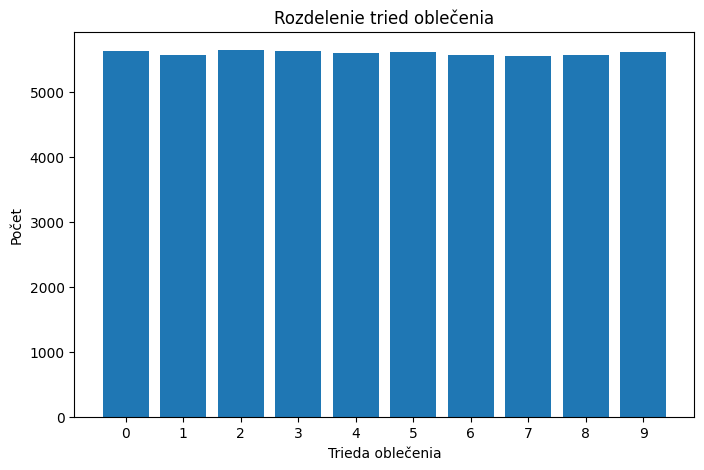

In [4]:
class_counts = df['label'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Trieda oblečenia')
plt.ylabel('Počet')
plt.title('Rozdelenie tried oblečenia')
plt.xticks(range(10))
plt.show()

### Zobrazenie náhodných obrázkov z datasetu

In [5]:
item_labels = ['Tricčko/Top', 'Nohavice', 'Pulover', 'Šaty', 'Kabát', 'Sandál', 'Košeľa', 'Teniska', 'Taška', 'Členková topánka']

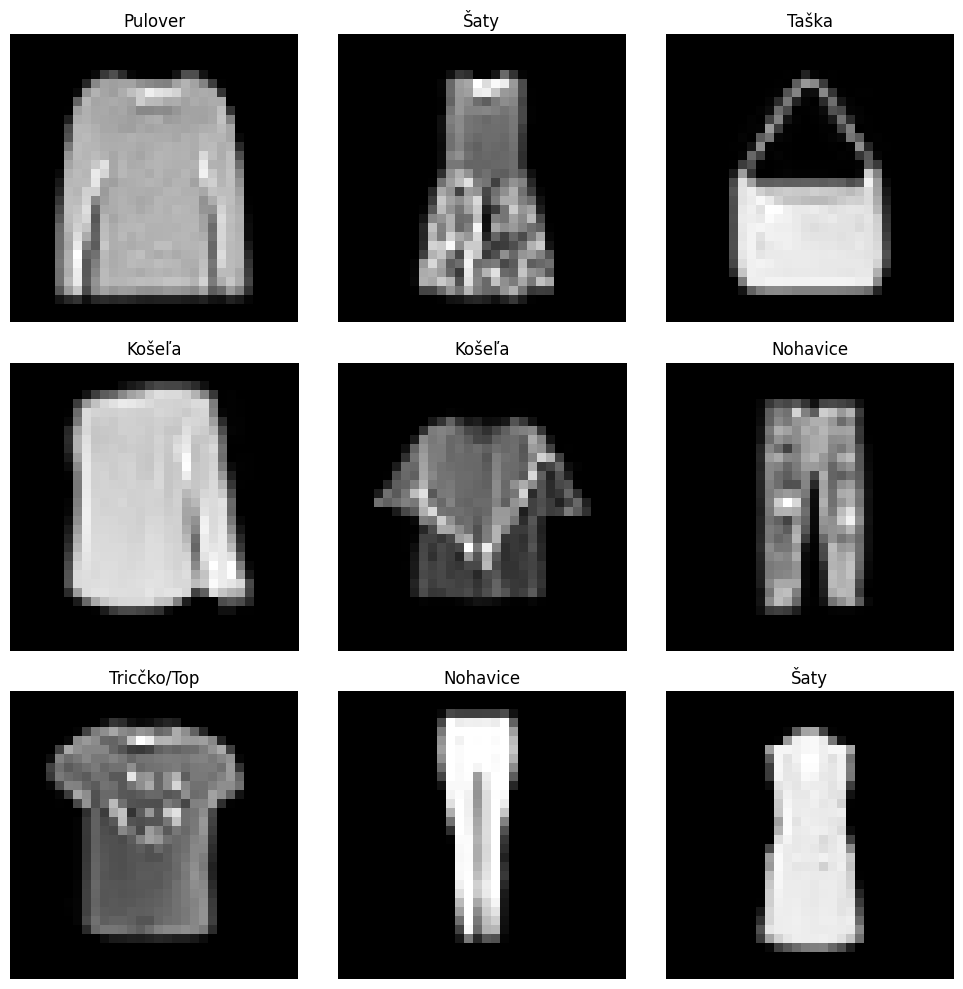

In [6]:
random_images = df.sample(9, random_state=42)
images = random_images.drop('label', axis=1).values
labels = random_images['label'].values

plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).reshape(32, 32), cmap='gray')
    plt.title(item_labels[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

Dáta si náhodne rozdelíme na trénovaciu, validačnú a testovaciu podmnožinu.

In [93]:
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42)

Pripravíme si **štandardizované** a **normalizované** dáta, ktoré by nám mohli pomôcť zlepšit presnosť modelu.

In [8]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [9]:
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_val_normalized = normalizer.transform(X_val)

## Dopredná neurónová sieť

Začneme s jednoduchým modelom doprednej siete, ktorý bude mať len jednu skrytú vrstvu s 64 neurónmi.

In [32]:
basic_model = keras.Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(10, activation='softmax')
    ])

basic_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
basic_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=3)
print(f'Validačná presnosť: {basic_model.evaluate(X_val, y_val)[1]}')

Epoch 1/10


2023-05-18 21:20:25.563809: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 275251200 exceeds 10% of free system memory.


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
490/490 [==============================] - 1s 2ms/step - loss: 1.2234 - accuracy: 0.6445
Validačná presnosť: 0.6444515585899353


Dosiahli sme presnosti len približne 64%, čo nie je dosť. Skúsime teda použiť naše transformované dáta.

In [11]:
basic_model.fit(X_train_std, y_train, epochs=10, batch_size=32, validation_data=(X_val_std, y_val), verbose=3)
print(f'Validačná presnosť: {basic_model.evaluate(X_val_std, y_val)[1]}')

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
490/490 [==============================] - 1s 1ms/step - loss: 0.5767 - accuracy: 0.8258
Validačná presnosť: 0.8258290886878967


In [12]:
basic_model.fit(X_train_normalized, y_train, epochs=10, batch_size=32, validation_data=(X_val_normalized, y_val), verbose=3)
print(f'Validačná presnosť: {basic_model.evaluate(X_val_normalized, y_val)[1]}')

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
490/490 [==============================] - 1s 1ms/step - loss: 0.5118 - accuracy: 0.8409
Validačná presnosť: 0.8409438729286194


Obe transformácie výzazne zlepšili funkčnosť modelu, takže od tejto chvíle budeme modely trénovať len na nich.

### Ladenie hyperparametrov

Bohužiaľ, keďže chcem, aby môj počítač vydržal túto úlohu, nebudem môcť ladiť všetky hyperparametre naraz, ale namiesto toho si vždy vyberiem jeden, ktorý nájdem optimálny, a ten potom používam pri zisťovaní ďalších optimálnych hyperparametrov.

In [38]:
def build_model(hidden_layers=(64,), activation='relu', dropout_rate=0, optimizer='adam', regularization=None, regularization_rate=0.001):
    model = keras.Sequential()
    for units in hidden_layers:
        if regularization:
            model.add(Dense(units, activation=activation, kernel_regularizer=regularization(regularization_rate)))
        else:
            model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [39]:
param_grid = {
    'hidden_layers': [(64,), (128,), (128, 64)],
}

model = KerasClassifier(build_fn=build_model)

grid = GridSearchCV(model, param_grid, cv=5, verbose=0)
grid.fit(X_train_std, y_train)

1050/1050 [==============================] - 4s 3ms/step - loss: 0.7275 - accuracy: 0.7369


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa865775ea0>,
             param_grid={'hidden_layers': [(64,), (128,), (128, 64)]})

In [40]:
param_grid = {
    'hidden_layers': [grid.best_params_['hidden_layers']],
    'activation': ['relu', 'tanh']
}

model = KerasClassifier(build_fn=build_model)

grid = GridSearchCV(model, param_grid, cv=5, verbose=0)
grid.fit(X_train_std, y_train)

1050/1050 [==============================] - 3s 3ms/step - loss: 0.7260 - accuracy: 0.7437


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa82ce7b100>,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layers': [(128, 64)]})

In [41]:
param_grid = {
    'hidden_layers': [grid.best_params_['hidden_layers']],
    'activation': [grid.best_params_['activation']],
    'optimizer': ['adam', 'rmsprop']
}

model = KerasClassifier(build_fn=build_model)

grid = GridSearchCV(model, param_grid, cv=5, verbose=0)
grid.fit(X_train_std, y_train)

1050/1050 [==============================] - 3s 2ms/step - loss: 0.7191 - accuracy: 0.7446


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa778679960>,
             param_grid={'activation': ['tanh'], 'hidden_layers': [(128, 64)],
                         'optimizer': ['adam', 'rmsprop']})

In [42]:
param_grid = {
    'hidden_layers': [grid.best_params_['hidden_layers']],
    'activation': [grid.best_params_['activation']],
    'optimizer': [grid.best_params_['optimizer']],
    'dropout_rate': [0.0, 0.25, 0.5]
}

model = KerasClassifier(build_fn=build_model)

grid = GridSearchCV(model, param_grid, cv=5, verbose=0)
grid.fit(X_train_std, y_train)

1050/1050 [==============================] - 3s 2ms/step - loss: 0.7178 - accuracy: 0.7408


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa794916800>,
             param_grid={'activation': ['tanh'],
                         'dropout_rate': [0.0, 0.25, 0.5],
                         'hidden_layers': [(128, 64)],
                         'optimizer': ['rmsprop']})

In [43]:
param_grid = {
    'hidden_layers': [grid.best_params_['hidden_layers']],
    'activation': [grid.best_params_['activation']],
    'optimizer': [grid.best_params_['optimizer']],
    'dropout_rate': [grid.best_params_['dropout_rate']],
    'regularization': [None, keras.regularizers.l2, keras.regularizers.l2],
    'regularization_rate': [0.01, 0.1, 1]
}

model = KerasClassifier(build_fn=build_model)

grid = GridSearchCV(model, param_grid, cv=5, verbose=0)
grid.fit(X_train_std, y_train)

1050/1050 [==============================] - 3s 3ms/step - loss: 0.7167 - accuracy: 0.7431


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa794aec0a0>,
             param_grid={'activation': ['tanh'], 'dropout_rate': [0.0],
                         'hidden_layers': [(128, 64)], 'optimizer': ['rmsprop'],
                         'regularization': [None,
                                            <class 'keras.regularizers.L2'>,
                                            <class 'keras.regularizers.L2'>],
                         'regularization_rate': [0.01, 0.1, 1]})

In [44]:
model = build_model(**grid.best_params_)
model.fit(X_train_std, y_train, epochs=10, batch_size=32, validation_data=(X_val_std, y_val), verbose=3)
print(f'Validačná presnosť: {model.evaluate(X_val_std, y_val)[1]}')

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
490/490 [==============================] - 1s 1ms/step - loss: 0.4930 - accuracy: 0.8275
Validačná presnosť: 0.8274872303009033


In [45]:
model.fit(X_train_normalized, y_train, epochs=10, batch_size=32, validation_data=(X_val_normalized, y_val), verbose=3)
print(f'Validačná presnosť: {model.evaluate(X_val_normalized, y_val)[1]}')

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
490/490 [==============================] - 1s 1ms/step - loss: 0.4647 - accuracy: 0.8449
Validačná presnosť: 0.844897985458374


Najvyššiu presnosť za použitia doprednej neurónovej siete sme dostali pri trénovaní na normalizovaných dátach a s parametrami:

In [46]:
grid.best_params_

{'activation': 'tanh',
 'dropout_rate': 0.0,
 'hidden_layers': (128, 64),
 'optimizer': 'rmsprop',
 'regularization': None,
 'regularization_rate': 1}

## Konvolučná neurónová sieť

Budeme potrebovať dáta v inom formáte, takže si ich reshapeneme. Pri všetkých pokusoch s doprednými sieťami sme dostali najlepšie výsledky pri použití normalizovaných dát, takže som sa rozhodol naďalej používať už len tieto dáta.

In [94]:
X_train = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 32, 32, 1))
X_val = np.reshape(X_val_normalized, (X_val_normalized.shape[0], 32, 32, 1))

In [140]:
basic_cnn = Sequential()
basic_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
basic_cnn.add(MaxPooling2D((2, 2)))
basic_cnn.add(Flatten())
basic_cnn.add(Dense(64, activation='relu'))
basic_cnn.add(Dense(10, activation='softmax'))

basic_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

basic_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

print(f'Validačná presnosť: {basic_cnn.evaluate(X_val, y_val)[1]}')

Epoch 1/10
1050/1050 [==============================] - 13s 12ms/step - loss: 0.6307 - accuracy: 0.7696 - val_loss: 0.4838 - val_accuracy: 0.8279
Epoch 2/10
1050/1050 [==============================] - 12s 12ms/step - loss: 0.4288 - accuracy: 0.8454 - val_loss: 0.4040 - val_accuracy: 0.8577
Epoch 3/10
1050/1050 [==============================] - 13s 12ms/step - loss: 0.3710 - accuracy: 0.8632 - val_loss: 0.3799 - val_accuracy: 0.8640
Epoch 4/10
1050/1050 [==============================] - 13s 12ms/step - loss: 0.3300 - accuracy: 0.8792 - val_loss: 0.3719 - val_accuracy: 0.8658
Epoch 5/10
1050/1050 [==============================] - 12s 12ms/step - loss: 0.3014 - accuracy: 0.8889 - val_loss: 0.3792 - val_accuracy: 0.8652
Epoch 6/10
1050/1050 [==============================] - 12s 12ms/step - loss: 0.2744 - accuracy: 0.8988 - val_loss: 0.3495 - val_accuracy: 0.8765
Epoch 7/10
1050/1050 [==============================] - 12s 11ms/step - loss: 0.2532 - accuracy: 0.9079 - val_loss: 0.3590 -

Už aj pri úplne jednoduchej konvolučnej neurónovej sieti sme dostali lepšie výsledky, ako pri doprednej neurónovej sieti s vyladenými hyperparametrami. <br>
Skúsime do nej ešte pridať ďalšie vrstvy s konvolúciou.

In [154]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(32, 32, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
print(f'Validačná presnosť: {model.evaluate(X_val, y_val)[1]}')

Epoch 1/10
1050/1050 [==============================] - 20s 18ms/step - loss: 0.7654 - accuracy: 0.7118 - val_loss: 0.4858 - val_accuracy: 0.8198
Epoch 2/10
1050/1050 [==============================] - 19s 18ms/step - loss: 0.5226 - accuracy: 0.8061 - val_loss: 0.4005 - val_accuracy: 0.8483
Epoch 3/10
1050/1050 [==============================] - 19s 18ms/step - loss: 0.4516 - accuracy: 0.8313 - val_loss: 0.3632 - val_accuracy: 0.8652
Epoch 4/10
1050/1050 [==============================] - 19s 18ms/step - loss: 0.4157 - accuracy: 0.8456 - val_loss: 0.3400 - val_accuracy: 0.8747
Epoch 5/10
1050/1050 [==============================] - 19s 18ms/step - loss: 0.3888 - accuracy: 0.8545 - val_loss: 0.3230 - val_accuracy: 0.8797
Epoch 6/10
1050/1050 [==============================] - 18s 17ms/step - loss: 0.3734 - accuracy: 0.8618 - val_loss: 0.3147 - val_accuracy: 0.8828
Epoch 7/10
1050/1050 [==============================] - 19s 18ms/step - loss: 0.3583 - accuracy: 0.8671 - val_loss: 0.3130 -

To model zlepšilo ešte viac. Taktiež by mohlo pomôcť viac epoch. Použijeme teda **early stopping**, ktorý zastaví trénovanie, ak sa medzi epochami model prestane zlepšovať.

In [144]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
print(f'Validačná presnosť: {model.evaluate(X_val, y_val)[1]}')

Epoch 1/20
1050/1050 [==============================] - 20s 19ms/step - loss: 0.3225 - accuracy: 0.8809 - val_loss: 0.2878 - val_accuracy: 0.8950
Epoch 2/20
1050/1050 [==============================] - 21s 20ms/step - loss: 0.3174 - accuracy: 0.8805 - val_loss: 0.2872 - val_accuracy: 0.8952
Epoch 3/20
1050/1050 [==============================] - 20s 19ms/step - loss: 0.3089 - accuracy: 0.8833 - val_loss: 0.2927 - val_accuracy: 0.8900
Epoch 4/20
1050/1050 [==============================] - 18s 17ms/step - loss: 0.3030 - accuracy: 0.8855 - val_loss: 0.2822 - val_accuracy: 0.8969
Epoch 5/20
1050/1050 [==============================] - 18s 17ms/step - loss: 0.2964 - accuracy: 0.8880 - val_loss: 0.3045 - val_accuracy: 0.8885
Epoch 6/20
1050/1050 [==============================] - 19s 18ms/step - loss: 0.2951 - accuracy: 0.8896 - val_loss: 0.2838 - val_accuracy: 0.8960
Epoch 7/20
1050/1050 [==============================] - 19s 18ms/step - loss: 0.2909 - accuracy: 0.8908 - val_loss: 0.2792 -

In [145]:
def plot_image(image_index, predictions_array, image_labels, images):
  true_label = image_labels.iloc[image_index]
  img = images[image_index]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap='gray')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(item_labels[predicted_label],
                                100*np.max(predictions_array),
                                item_labels[true_label]),
                                color=color)


def plot_value_array(image_index, predictions_array, image_labels):
  true_label = image_labels.iloc[image_index]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [151]:
predictions = model.predict(X_val)

490/490 [==============================] - 2s 4ms/step


Zobrazíme si niekoľko obrázkov z validačnej množiny, a taktiež pravdepodobnosti, ktoré sme dostali pri trénovaní.

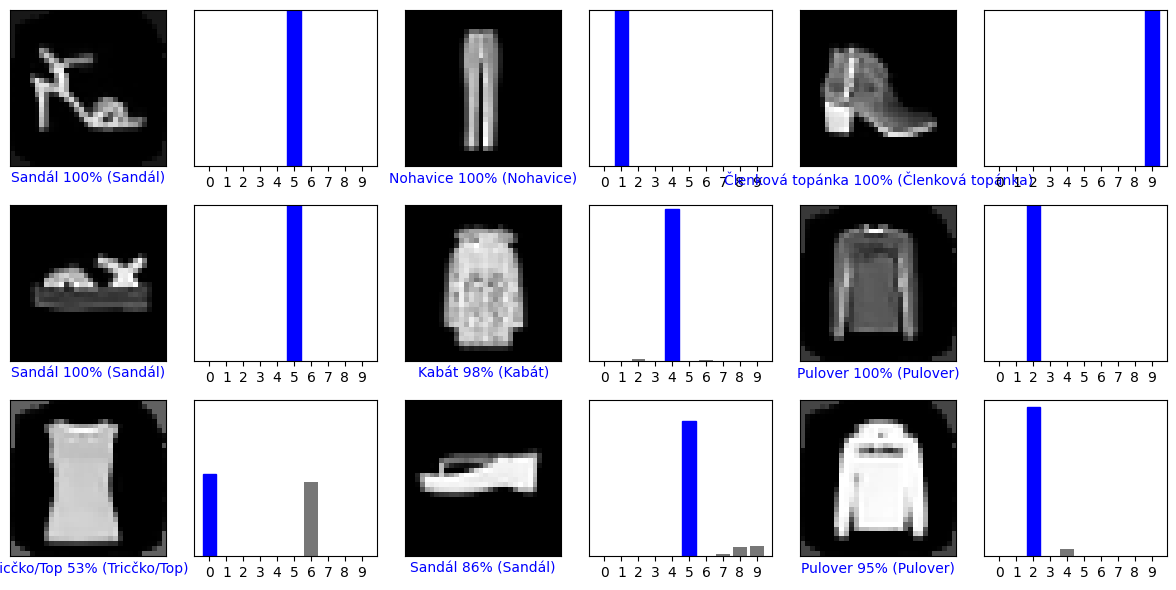

In [152]:
num_rows = 3
num_cols = 3
num_images = num_cols*num_rows
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_val, X_val)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_val)

plt.tight_layout()
plt.show()

Finálny model otestujeme na testovacích dátach, aby sme zistili, akú presnosť môžeme očakávať na náhodných dátach.

In [158]:
X_test_normalized = normalizer.transform(X_test)
X_test_reshaped = np.reshape(X_test_normalized, (X_test_normalized.shape[0], 32, 32, 1))

print(f'Testovacia presnosť: {model.evaluate(X_test_reshaped, y_test)[1]}')

210/210 [==============================] - 1s 4ms/step - loss: 33.7460 - accuracy: 0.7897
Testovacia presnosť: 0.7897321581840515


:((

### Vytvorenie súboru `results.csv`

In [136]:
df_eval = pd.read_csv('evaluate.csv')
X_eval = df_eval.drop(columns='ID')
eval_id = df_eval['ID']

In [137]:
X_eval_normalized = normalizer.transform(X_eval)
X_eval_reshaped = np.reshape(X_eval_normalized, (X_eval_normalized.shape[0], 32, 32, 1))
predictions = model.predict(X_eval_reshaped)

438/438 [==============================] - 2s 4ms/step


In [138]:
predicted_values = [np.argmax(prediction) for prediction in predictions]

In [141]:
data = pd.DataFrame({'ID': eval_id, 'predikce labelu': predicted_values})
data.to_csv('results.csv', index=False)